In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split # 학습, 테스트set 구분
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('preprocessing2.csv', encoding = 'cp949', index_col=0 )
df

,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,dtir1,...,co-applicant_credit_type_EXP,submission_of_application_not_inst,submission_of_application_to_inst,Region_North,Region_North-East,Region_central,Region_south,Security_Type_Indriect,Security_Type_direct,Status
0,-0.750000,4.311449,0.636128,0.168877,360.0,-0.857143,-0.858974,758.0,0.974394,45.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1
1,-0.375000,4.719152,1.579036,-0.890382,360.0,-0.844678,-0.166667,552.0,0.741857,34.376016,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1
2,0.458333,4.560000,0.200000,-0.488242,360.0,0.257143,0.794872,834.0,0.228647,46.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0
3,0.666667,4.250000,0.681000,-0.159712,360.0,0.685714,1.307692,587.0,-0.195575,42.000000,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
4,1.666667,4.000000,0.304200,-0.639929,360.0,0.971429,1.000000,602.0,0.701661,39.000000,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143978,0.583333,3.125000,0.257100,1.899229,180.0,0.542857,0.448718,659.0,-0.099279,48.000000,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0
143979,1.208333,5.190000,0.854400,-0.639929,360.0,1.057143,0.294872,569.0,0.005799,15.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
143980,0.625000,3.125000,0.081600,-0.327215,180.0,0.885714,0.243590,702.0,-0.516229,49.000000,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
143981,-0.416667,3.500000,0.582400,0.462241,180.0,-0.400000,0.294872,737.0,-0.143496,29.000000,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0


In [3]:
seed = 5764

X=df.drop('Status',axis=1)
Y=df['Status']

# 학습, 테스트 데이터 분리 (0.7:0.3)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)

In [4]:
y_train.shape

(100788,)

In [5]:
y_train.value_counts()

0    76159
1    24629
Name: Status, dtype: int64

In [6]:
#불균형 비율 보기
y_train.value_counts().iloc[0]/y_train.value_counts().iloc[1]

3.0922489747858215

In [4]:
def default_model(algorithm, x_train, y_train, x_test, y_test):
    model_1=algorithm(random_state=seed)
    model_1.fit(x_train,y_train) #학습
    default_trainScore = model_1.score(x_train, y_train)
    default_testScore = model_1.score(x_test, y_test)
    pred_1= model_1.predict(x_test)
    print("학습 데이터셋 정확도: ", default_trainScore)
    print("테스트 데이터셋 정확도: ", default_testScore)
    print("혼돈행렬: ", confusion_matrix(y_test,pred_1))
    print("Accuracy ",accuracy_score(y_test, pred_1))
    print("Precision ",precision_score(y_test, pred_1))
    print("Recall Score ",recall_score(y_test, pred_1))
    print("F1 Score ",f1_score(y_test, pred_1))
    print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, pred_1))

In [5]:
#하이퍼파라미터에 따른 모델 시각화 함수
def optimal_visualization(algorithmName, x_values, train_score, test_score, xlabel):
    plt.plot(x_values, train_score, linestyle = '-', label = 'train score')
    plt.plot(x_values, test_score, linestyle = '--', label= 'test score')
    plt.ylabel('Accuracy(%)')
    plt.xlabel(xlabel)
    plt.legend() #범례표시

In [6]:
#트리 개수 조정 함수 5개씩 늘려간다
def optimal_estimator(algorithm, algorithmName, x_train, y_train, x_test, y_test, n_estimator_min, n_estimator_max):
    train_score = []; test_score = []
    param_tree = [n_tree*5 for n_tree in range(n_estimator_min, n_estimator_max)]
    
    for v_n_estimators in param_tree:
        model=algorithm(n_estimators = v_n_estimators, random_state=seed,  n_jobs=-1)
        model.fit(x_train,y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))
    
    df_score_n = pd.DataFrame({'n_estimatros': param_tree, 'TrainScore': train_score, 'TestScore': test_score})
    optimal_visualization(algorithmName, param_tree, train_score, test_score, "esimator number")
    print(round(df_score_n, 5))

In [7]:
#최대 깊이 조정 함수 max_depth
def optimal_maxdepth(algorithm, algorithmName, x_train, y_train, x_test, y_test, depth_min, depth_max, n_estimator):
    train_score = []; test_score = []
    param_depth = [n_depth for n_depth in range(depth_min, depth_max)]
    
    for v_max_depth in param_depth:
        model=algorithm(max_depth= v_max_depth,
                        n_estimators= n_estimator,
                        random_state=seed,
                        n_jobs=-1)
        model.fit(x_train,y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))
        
    df_score_n = pd.DataFrame({'n_depth': param_depth, 'TrainScore': train_score, 'TestScore': test_score})
    optimal_visualization(algorithmName, param_depth, train_score, test_score, "depth number")
    print(round(df_score_n, 5))

In [8]:
#잎이 아닌 노드 최소 샘플 개수 조정 함수 min_samples_split. random seach로는 최적화 못하는 듯함
#값이 크면 과소적합될 가능성 있음
#training dataset 개수 보고 결정하기
def optimal_minsplit(algorithm, algorithmName, x_train, y_train, x_test, y_test, split_min, split_max, n_estimator, n_depth):
    train_score = []; test_score = []
    param_split= [n_split*2 for n_split in range(split_min, split_max)]
    
    for v_min_samples_split in param_split:
        model=algorithm(min_samples_split=v_min_samples_split,
                        n_estimators= n_estimator,
                        max_depth = n_depth,
                        random_state=seed,
                        n_jobs=-1)
        model.fit(x_train,y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))
    
    df_score_n = pd.DataFrame({'n_samples_split': param_split,'TrainScore': train_score, 'TestScore': test_score})
    optimal_visualization(algorithmName,param_split,train_score, test_score,"samples_split number")
    print(round(df_score_n, 5))

In [9]:
#잎 노드 최소 샘플 개수 조정 함수 min_samples_leaf
def optimal_minsleaf(algorithm, algorithmName, x_train, y_train, x_test, y_test, leaf_min, leaf_max, n_estimator, n_depth, n_split):
    train_score = []; test_score = []
    param_leaf= [n_leaf*2 for n_leaf in range(leaf_min, leaf_max)]
    
    for v_min_samples_leaf in param_leaf:
        model=algorithm(min_samples_leaf=v_min_samples_leaf,
                        n_estimators= n_estimator,
                        max_depth = n_depth,
                        min_samples_split = n_split,
                        random_state=seed,
                        n_jobs=-1)
        model.fit(x_train,y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))
    
    df_score_n = pd.DataFrame({'n_samples_leaf': param_leaf,'TrainScore': train_score, 'TestScore': test_score})
    optimal_visualization(algorithmName,param_leaf,train_score, test_score,"samples_leaf number")
    print(round(df_score_n, 5))

In [10]:
def rfmodel(algorithm, algorithmName, x_train, y_train, x_test, y_test, leaf_min, leaf_max, n_estimator, n_depth, n_split, n_leaf):
    model=algorithm(n_estimators= n_estimator,
                    max_depth = n_depth,
                    min_samples_split = n_split,
                    min_samples_leaf=n_leaf,
                    random_state=seed,
                    n_jobs=-1) #cpu 코어
    
    model.fit(x_train,y_train)
    
    train_accu = print(model.score(x_train, y_train))
    test_accu = print(model.score(x_test, y_test))
    pred= model.predict(x_test)
    
    #성능평가
    print("Accuracy ",accuracy_score(y_test, pred))
    print("Precision ",precision_score(y_test, pred))
    print("Recall Score ",recall_score(y_test, pred))
    print("F1 Score ",f1_score(y_test, pred))
    print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, pred))
    
    #혼돈행렬
    plt.figure(figsize=(30,30))
    plot_confusion_matrix(model,x_test,y_test, include_values=True,
                          display_labels=[0,1])
    plt.show()

In [50]:
# 교차검증
rf= RandomForestClassifier()
X=df.drop('Status',axis=1)
Y=df['Status']
# 각 폴드의 스코어 
scores = cross_val_score(rf, X, Y, cv = 5)

print('Averaged results of cross validation: ', scores.mean())
#교차검증 평균

Averaged results of cross validation:  0.964968076032638


*3분 정도 걸렸음

In [51]:
pd.DataFrame(cross_validate(rf, X, Y, cv =5))

,fit_time,score_time,test_score
0,39.038353,1.371207,0.966073
1,40.562467,1.504128,0.965239
2,37.691134,1.262272,0.965830
3,38.030938,1.363209,0.964127
4,40.340595,1.205303,0.964127


In [11]:
algorithm= RandomForestClassifier
algorithmName='랜덤포레스트'

In [49]:
default_model(algorithm, x_train, y_train, x_test, y_test)

학습 데이터셋 정확도:  1.0
테스트 데이터셋 정확도:  0.9634216923255007
혼돈행렬:  [[32406   148]
 [ 1432  9209]]
Accuracy  0.9634216923255007
Precision  0.9841829646254141
Recall Score  0.8654261817498355
F1 Score  0.920992099209921
Balanced Accuracy Score  0.9304399447177635


* 과적합 상태

    n_estimatros  TrainScore  TestScore
0              5     0.99434    0.94409
1             10     0.99741    0.95034
2             15     0.99938    0.96085
3             20     0.99961    0.95777
4             25     0.99989    0.96206
5             30     0.99987    0.96057
6             35     0.99994    0.96273
7             40     0.99994    0.96266
8             45     0.99998    0.96432
9             50     0.99998    0.96261
10            55     1.00000    0.96405
11            60     0.99999    0.96284
12            65     1.00000    0.96296
13            70     1.00000    0.96155
14            75     1.00000    0.96303
15            80     1.00000    0.96236
16            85     1.00000    0.96356
17            90     1.00000    0.96338
18            95     1.00000    0.96414
19           100     1.00000    0.96342
20           105     1.00000    0.96398
21           110     1.00000    0.96335
22           115     1.00000    0.96416
23           120     1.00000    0.96386


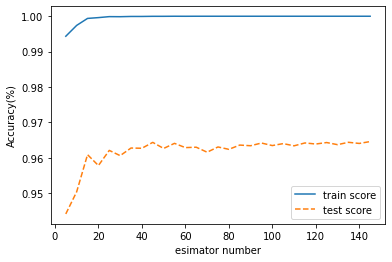

In [34]:
n_estimator_min=1
n_estimator_max=30
optimal_estimator(algorithm, algorithmName, x_train, y_train, x_test, y_test, n_estimator_min, n_estimator_max)

* 트리 개수 55부터 과적합
* 그러나 트리 개수는 많으면 좋은 성능을 보일 수 있다 함
* 15와 25도 좋아보임(나중에 gridsearch 해볼 것)

In [12]:
n_estimator = 45
#n_estimator = 15
# 55 미만인 것 중 TestScore 높은거 선택

    n_depth  TrainScore  TestScore
0         1     0.75965    0.75745
1         2     0.85594    0.85410
2         3     0.85745    0.85552
3         4     0.86013    0.85811
4         5     0.86228    0.85996
5         6     0.86723    0.86480
6         7     0.87025    0.86765
7         8     0.87481    0.87066
8         9     0.88317    0.87832
9        10     0.89313    0.88670
10       11     0.90112    0.89300
11       12     0.90914    0.89915
12       13     0.92258    0.90934
13       14     0.92933    0.91497
14       15     0.93950    0.92265
15       16     0.95183    0.93224
16       17     0.95810    0.93559
17       18     0.96644    0.94300
18       19     0.97483    0.94791


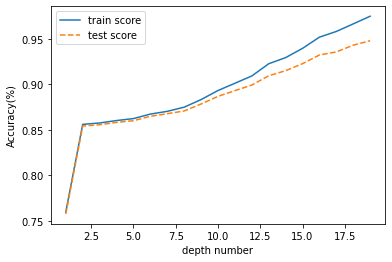

In [40]:
depth_min=1
depth_max=20
optimal_maxdepth(algorithm, algorithmName, x_train, y_train, x_test, y_test, depth_min, depth_max, n_estimator)

In [33]:
train_Minus_test = []
#최대 깊이 조정 함수 max_depth
def optimal_maxdepth(algorithm, algorithmName, x_train, y_train, x_test, y_test, depth_min, depth_max, n_estimator):
    train_score = []; test_score = []; train_Minus_test = []
    param_depth = [n_depth for n_depth in range(depth_min, depth_max)]
    
    for v_max_depth in param_depth:
        model=algorithm(max_depth= v_max_depth,
                        n_estimators= n_estimator,
                        random_state=seed,
                        n_jobs=-1)
        model.fit(x_train,y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))
        train_Minus_test.append(model.score(x_train, y_train)-model.score(x_test, y_test))
        
    df_score_n = pd.DataFrame({'n_depth': param_depth, 'TrainScore': train_score, 'TestScore': test_score, 'Train-Test': train_Minus_test})
    optimal_visualization(algorithmName, param_depth, train_score, test_score, "depth number")
    print(round(df_score_n, 5))

    n_depth  TrainScore  TestScore  Train-Test
0         1     0.75965    0.75745     0.00221
1         2     0.85594    0.85410     0.00183
2         3     0.85745    0.85552     0.00194
3         4     0.86013    0.85811     0.00202
4         5     0.86228    0.85996     0.00231
5         6     0.86723    0.86480     0.00243
6         7     0.87025    0.86765     0.00261
7         8     0.87481    0.87066     0.00415
8         9     0.88317    0.87832     0.00485
9        10     0.89313    0.88670     0.00643
10       11     0.90112    0.89300     0.00812
11       12     0.90914    0.89915     0.00998
12       13     0.92258    0.90934     0.01324
13       14     0.92933    0.91497     0.01436
14       15     0.93950    0.92265     0.01684
15       16     0.95183    0.93224     0.01959
16       17     0.95810    0.93559     0.02251
17       18     0.96644    0.94300     0.02344
18       19     0.97483    0.94791     0.02692


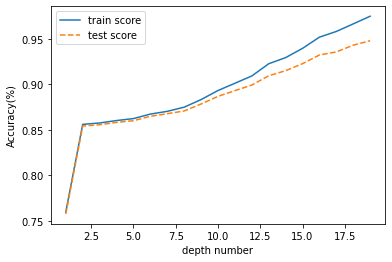

In [34]:
depth_min=1
depth_max=20
optimal_maxdepth(algorithm, algorithmName, x_train, y_train, x_test, y_test, depth_min, depth_max, n_estimator)

    n_depth  TrainScore  TestScore
0        20     0.97909    0.94698
1        21     0.98637    0.95236
2        22     0.98899    0.95379
3        23     0.99351    0.95571
4        24     0.99580    0.95942
5        25     0.99729    0.96067
6        26     0.99876    0.96171
7        27     0.99903    0.96196
8        28     0.99965    0.96270
9        29     0.99985    0.96458
10       30     0.99993    0.96331


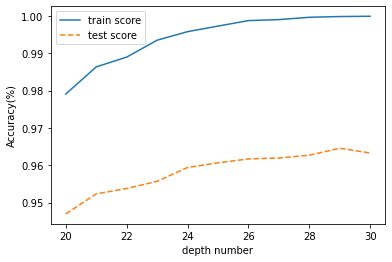

In [41]:
depth_min=20
depth_max=31
optimal_maxdepth(algorithm, algorithmName, x_train, y_train, x_test, y_test, depth_min, depth_max, n_estimator)

* 깊어질 수록 테스트 score 올라감
* 30에서 감소될 것 같음

    n_depth  TrainScore  TestScore
0        30     0.99993    0.96331
1        31     0.99991    0.96502
2        32     0.99996    0.96398
3        33     0.99997    0.96127
4        34     0.99995    0.96363
5        35     0.99998    0.96361
6        36     0.99997    0.96423
7        37     0.99995    0.96458
8        38     0.99998    0.96555
9        39     0.99999    0.96407
10       40     0.99998    0.96493


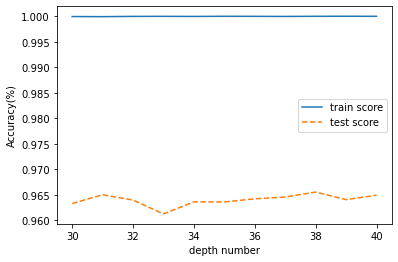

In [42]:
depth_min=30
depth_max=41
optimal_maxdepth(algorithm, algorithmName, x_train, y_train, x_test, y_test, depth_min, depth_max, n_estimator)

In [13]:
#n_depth = 31
#n_depth = 38
n_depth = 12

    n_samples_split  TrainScore  TestScore
0                 2     0.90914    0.89915
1                 4     0.91410    0.90376
2                 6     0.90857    0.89890
3                 8     0.91174    0.90223
4                10     0.91395    0.90548
5                12     0.91102    0.90138
6                14     0.90556    0.89703
7                16     0.90733    0.89948
8                18     0.90705    0.89865
9                20     0.90941    0.90050
10               22     0.90359    0.89564
11               24     0.90216    0.89469
12               26     0.90750    0.90024
13               28     0.90245    0.89459
14               30     0.90918    0.90168
15               32     0.90878    0.90186
16               34     0.91026    0.90226
17               36     0.90897    0.90112
18               38     0.90717    0.90015
19               40     0.90817    0.90068
20               42     0.90576    0.89862
21               44     0.90698    0.89973
22         

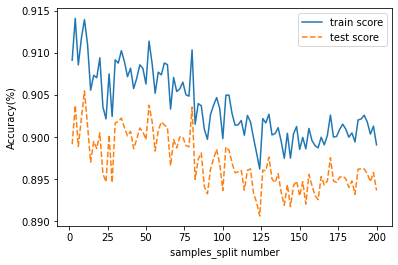

In [14]:
split_min=1
split_max=101
# 데이터프레임 행 최대 100개까지 반드시 출력
pd.set_option('display.max_row', 100)
optimal_minsplit(algorithm, algorithmName, x_train, y_train, x_test, y_test, split_min, split_max, n_estimator, n_depth)

*25분정도 걸림
*같이 감소함
*train과 test score 차이가 적은 것을 선택할 것

In [15]:
#잎이 아닌 노드 최소 샘플 개수 조정 함수 min_samples_split. random seach로는 최적화 못하는 듯함
#값이 크면 과소적합될 가능성 있음
#training dataset 개수 보고 결정하기
def optimal_minsplit_re(algorithm, algorithmName, x_train, y_train, x_test, y_test, split_min, split_max, n_estimator, n_depth):
    train_score = []; test_score = []; train_Minus_test = []
    param_split= [n_split*2 for n_split in range(split_min, split_max)]
    
    for v_min_samples_split in param_split:
        model=algorithm(min_samples_split=v_min_samples_split,
                        n_estimators= n_estimator,
                        max_depth = n_depth,
                        random_state=seed,
                        n_jobs=-1)
        model.fit(x_train,y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))
        train_Minus_test.append(model.score(x_train, y_train)-model.score(x_test, y_test))
    
    df_score_n = pd.DataFrame({'n_samples_split': param_split,'TrainScore': train_score, 'TestScore': test_score, 'Train-Test': train_Minus_test})
    optimal_visualization(algorithmName,param_split,train_score, test_score,"samples_split number")
    print(round(df_score_n, 5))

    n_samples_split  TrainScore  TestScore  Train-Test
0                 2     0.90914    0.89915     0.00998
1                 4     0.91410    0.90376     0.01033
2                 6     0.90857    0.89890     0.00967
3                 8     0.91174    0.90223     0.00950
4                10     0.91395    0.90548     0.00847
5                12     0.91102    0.90138     0.00964
6                14     0.90556    0.89703     0.00854
7                16     0.90733    0.89948     0.00785
8                18     0.90705    0.89865     0.00841
9                20     0.90941    0.90050     0.00892
10               22     0.90359    0.89564     0.00795
11               24     0.90216    0.89469     0.00747
12               26     0.90750    0.90024     0.00726
13               28     0.90245    0.89459     0.00785
14               30     0.90918    0.90168     0.00750
15               32     0.90878    0.90186     0.00692
16               34     0.91026    0.90226     0.00800
17        

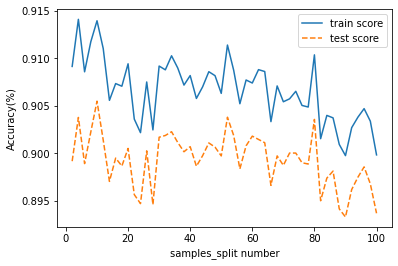

In [16]:
split_min=1
split_max=51
# 데이터프레임 행 최대 50개까지 반드시 출력
pd.set_option('display.max_row', 50)
optimal_minsplit_re(algorithm, algorithmName, x_train, y_train, x_test, y_test, split_min, split_max, n_estimator, n_depth)

*sampels_split number가 많아질수록 과적합 피하게 됨

In [17]:
n_split=52
#n_split=10
#n_split=16
#n_split=32
#n_split=60
#n_split=80

    n_samples_leaf  TrainScore  TestScore
0                2     0.90451    0.89735
1                4     0.90669    0.89997
2                6     0.90659    0.89957
3                8     0.90252    0.89554
4               10     0.90356    0.89656
5               12     0.90393    0.89770
6               14     0.90336    0.89672
7               16     0.90511    0.89869
8               18     0.90544    0.89832
9               20     0.90316    0.89730
10              22     0.90176    0.89510
11              24     0.90281    0.89647
12              26     0.90080    0.89499
13              28     0.90073    0.89492
14              30     0.89661    0.89121
15              32     0.89736    0.89200
16              34     0.90071    0.89369
17              36     0.89696    0.89154
18              38     0.90037    0.89469
19              40     0.90120    0.89494


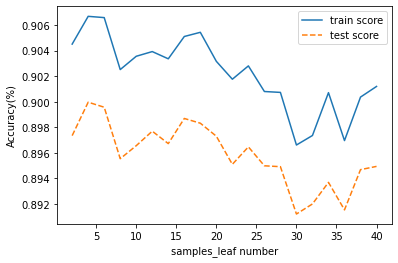

In [18]:
leaf_min=1
leaf_max=21
optimal_minsleaf(algorithm, algorithmName, x_train, y_train, x_test, y_test, leaf_min, leaf_max, n_estimator, n_depth, n_split)

In [19]:
n_leaf=6

0.9065861015200222
0.8995717096886213
Accuracy  0.8995717096886213
Precision  0.9800456968773801
Recall Score  0.6046424208251104
F1 Score  0.7478786469836104
Balanced Accuracy Score  0.8003091688815606


<Figure size 2160x2160 with 0 Axes>

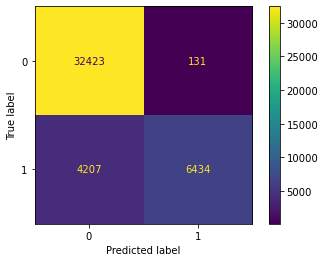

In [20]:
rfmodel(algorithm, algorithmName, x_train, y_train, x_test, y_test, leaf_min, leaf_max, n_estimator, n_depth, n_split, n_leaf)
#n_estimators=45
#n_depth = 12
#n_split=52
#n_leaf=6

In [22]:
algorithm = RandomForestClassifier(random_state=seed)
parameters = {'n_estimators':[15,25,45],
              'max_depth' :[8,12,31,38],
             'min_samples_split':[10,16,32,52,60,80]}

df_grid= GridSearchCV(algorithm, param_grid = parameters, cv=5, n_jobs=-1)

df_grid.fit(x_train, y_train)

result = pd.DataFrame(df_grid.cv_results_['params'])
result['mean_test_score']= df_grid.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False)
#mean_test_score이 젤 좋은 것

,max_depth,min_samples_split,n_estimators,mean_test_score
38,31,10,45,0.957217
54,38,10,15,0.956632
36,31,10,15,0.956552
37,31,10,25,0.956354
56,38,10,45,0.956255
...,...,...,...,...
7,8,32,25,0.873824
10,8,52,25,0.873775
11,8,52,45,0.873735
8,8,32,45,0.873467


In [24]:
algorithm = RandomForestClassifier(max_depth=31, min_samples_split=10, n_estimators=45)

In [26]:
def default_model(algorithm, x_train, y_train, x_test, y_test):
    model_1=algorithm
    model_1.fit(x_train,y_train) #학습
    default_trainScore = model_1.score(x_train, y_train)
    default_testScore = model_1.score(x_test, y_test)
    pred_1= model_1.predict(x_test)
    print("학습 데이터셋 정확도: ", default_trainScore)
    print("테스트 데이터셋 정확도: ", default_testScore)
    print("혼돈행렬: ", confusion_matrix(y_test,pred_1))
    print("Accuracy ",accuracy_score(y_test, pred_1))
    print("Precision ",precision_score(y_test, pred_1))
    print("Recall Score ",recall_score(y_test, pred_1))
    print("F1 Score ",f1_score(y_test, pred_1))
    print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, pred_1))

In [27]:
default_model(algorithm, x_train, y_train, x_test, y_test)

학습 데이터셋 정확도:  0.9908917728300988
테스트 데이터셋 정확도:  0.9573561754832736
혼돈행렬:  [[32384   170]
 [ 1672  8969]]
Accuracy  0.9573561754832736
Precision  0.981398402451034
Recall Score  0.8428719105347242
F1 Score  0.9068756319514661
Balanced Accuracy Score  0.918824909005766
